# [kaggleのタイタニック]

以下、今回の解析で重要なものについて。
+ Survived ... 1 -> 生存者(Alive), 0 ->死者(Dead)
+ Pclass ... 1,2,3の順に高級クラスの客室
+ Sex,Age ... それぞれ性別と年齢
+ SibSp ... 兄弟および配偶者の数
+ Parch ... 親もしくは子供の数
+ ticket... チケット番号
+ Fare ... 運賃
+ Embarked ... 乗船した港（３つ）


## 1. 入力

 ### 1.1 必要なライブラリなどをインポートする

In [153]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt

from collections import Counter

import re

# jupyter-notebookに描画する
%matplotlib inline

### 1.2 入力データを読み込む

In [154]:
# csvを読み込み、文字の変換を行う
titanic_df= pd.read_csv("./input/train.csv")

test= pd.read_csv("./input/test.csv")

titanic_df.info()
titanic_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. 外れ値の検討

### 2.1 外れ値の有無を検討する
- PassengerId〜Sex、Ticket, Cabin, Embarkedについては、項目の特性上「外れ値」にはならないと想定したため、Age, SibSp, Parch Fareについて外れ値を検討

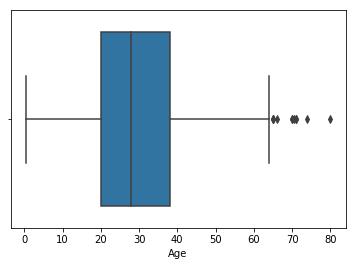

In [155]:
'''
[Age]
 箱ひげ図とカーネル密度推定からすると外れ値にしても良さそうなものがある
'''
sns.boxplot('Age',data=titanic_df)


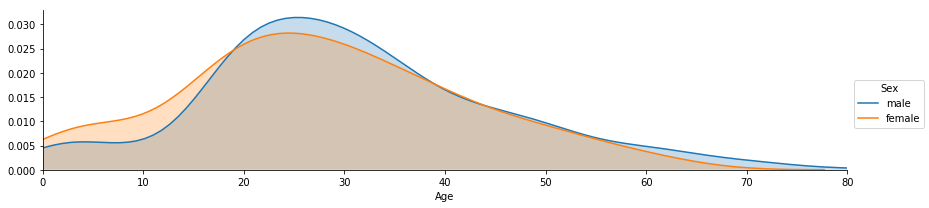

In [156]:
fig = sns.FacetGrid(titanic_df,hue='Sex', aspect=4)
fig.map(sns.kdeplot, 'Age', shade=True)
oldest = titanic_df['Age'].max()
fig.set(xlim=(0,oldest))
fig.add_legend()

,PassengerId,Survived,Pclass,Name,Sex,Age,Parch,Ticket,Fare,Cabin,Embarked
SibSp,,,,,,,,,,,
0,608,608,608,608,608,471,608,608,608,126,606
1,209,209,209,209,209,183,209,209,209,69,209
2,28,28,28,28,28,25,28,28,28,6,28
3,16,16,16,16,16,12,16,16,16,3,16
4,18,18,18,18,18,18,18,18,18,0,18
5,5,5,5,5,5,5,5,5,5,0,5
8,7,7,7,7,7,0,7,7,7,0,7


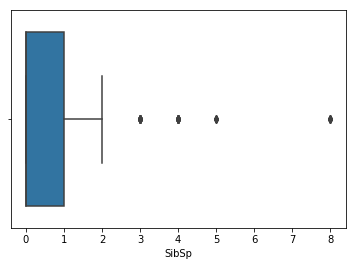

In [157]:
'''
[SibSp]
 箱ひげ図と実際のデータからすると外れ値と考える事は難しそう。
'''
sns.boxplot('SibSp',data=titanic_df)

titanic_df.groupby('SibSp').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Ticket,Fare,Cabin,Embarked
Parch,,,,,,,,,,,
0,678,678,678,678,678,521,678,678,678,141,676
1,118,118,118,118,118,110,118,118,118,39,118
2,80,80,80,80,80,68,80,80,80,23,80
3,5,5,5,5,5,5,5,5,5,0,5
4,4,4,4,4,4,4,4,4,4,1,4
5,5,5,5,5,5,5,5,5,5,0,5
6,1,1,1,1,1,1,1,1,1,0,1


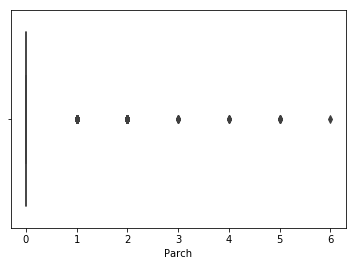

In [158]:
'''
[Parch]
 箱ひげ図と実際のデータからすると外れ値と考える事は難しそう。
'''
sns.boxplot('Parch',data=titanic_df)

titanic_df.groupby('Parch').count()

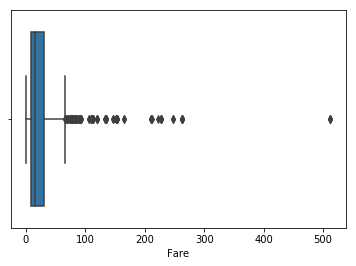

In [159]:
'''
[Fare]
 500以上の料金を払った人が外れ値として考えて良さそう。ただ、箱ひげ図で除外するのは止めたほうが良さそう
'''
sns.boxplot('Fare',data=titanic_df)

### 2.2 検討した結果を元に外れ値を削除する

In [160]:
'''
[Age]をYassine Ghouzamさんが作成したノートブックを参考に削除
'''

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        # Q1 = np.percentile(df[col], 25)
        Q1 = df[col].describe()['25%']
        # 3rd quartile (75%)
        #Q3 = np.percentile(df[col],75)
        Q3 = df[col].describe()['75%']
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
               
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(titanic_df,0,["Age"])

titanic_df.loc[Outliers_to_drop] # Show the outliers rows

titanic_df = titanic_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [161]:
'''
[Fare]の外れ値を削除
'''
Outliers_to_drop = titanic_df[titanic_df['Fare']>400].index

titanic_df.loc[Outliers_to_drop]

titanic_df = titanic_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)


## 3. 欠損値の対処

### 3.1 欠損に対処

In [169]:
# 解析するためにtestデータもくっつける
vtrain_len = len(titanic_df)
dataset =  pd.concat(objs=[titanic_df, test_df], axis=0).reset_index(drop=True)

In [170]:
# Sexにを値に置換
titanic_df['Sex'] =titanic_df['Sex'].replace('male',1)
titanic_df['Sex'] =titanic_df['Sex'].replace('female',2)

# Embarkedにを値に置換
Embarked_map_key = {'S':1,'C':2,'Q':3}
combine=[titanic_df]
for titanic_df in combine:
    titanic_df['Embarked']=titanic_df['Embarked'].map(Embarked_map_key)
    titanic_df['Embarked']=titanic_df['Embarked'].fillna(0)
    
# Nameに入っている　「○○.」を Salutation列を作って入れる
tmp=[]
for tmps in titanic_df['Name'].str.split(', '):
    tmp.append(tmps[1])

Salutation =[]
for Salutations in tmp:
    Salutation.append(Salutations.split('.')[0])
    
titanic_df['Salutation']=Salutation

combine=[titanic_df]

# Salutationから抜き出した内容をMr Miss Mrsなどに置換
combine=[titanic_df]

Salutation_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4} 
for titanic_df in combine:
        titanic_df['Salutation'] = titanic_df['Salutation'].map(Salutation_mapping) 
        titanic_df['Salutation'] = titanic_df['Salutation'].fillna(0)
        
tmp=[]
for tmps in test_df['Name'].str.split(', '):
    tmp.append(tmps[1])

Salutation =[]
for Salutations in tmp:
    Salutation.append(Salutations.split('.')[0])


In [164]:
# NULL値を補正
#titanic_df['Age'].fillna(titanic_df.Age.mean(), inplace=True) 
titanic_df['Age'].fillna(titanic_df.Age.median(), inplace=True) 
#test_df['Age'].fillna(test_df.Age.mean(),inplace=True)
test_df['Age'].fillna(test_df.Age.median(),inplace=True)

#test_df['Fare'].fillna(titanic_df.Pclass.mean(),inplace=True)
test_df['Fare'].fillna(titanic_df.Pclass.median(),inplace=True)

#test_df['Fare'].fillna(0,inplace=True)

In [165]:
combine=[titanic_df]
titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] + 1
for titanic_df in combine:
    titanic_df['IsAlone'] = 0
    titanic_df.loc[titanic_df['FamilySize'] == 1, 'IsAlone'] = 1

combine=[test_df]
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1
for test_df in combine:
    test_df['IsAlone'] = 0
    test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1

test_data = test_df.values

key =['Pclass','Sex','Age','SibSp','Parch','Fare','Salutation','IsAlone']
xs = titanic_df[key].values # Pclass以降の変数
y  = titanic_df['Survived']  # 正解データ

xs_test=test_df[key].values

In [166]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier()
random_forest.fit(xs, y)
Y_pred = random_forest.predict(xs_test)

import csv
with open("predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_df['PassengerId'].values.astype(int), Y_pred.astype(int)):
        writer.writerow([pid, survived])

## 4. 分析

### 4.1 ヒートマップ

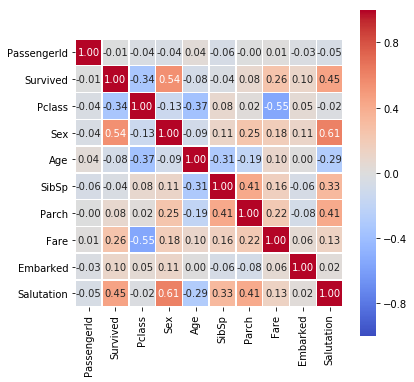

In [127]:
'''
ヒートマップを使用してSurvivedに効きそうな変数を特定する
Pclass, Sex, Fare, Salutationが効果が高そう
'''
corrmat = titanic_df.corr()
plt.subplots(figsize=(6,6))
sns.heatmap(corrmat, vmax=1,vmin=-1, square=True, annot=True, fmt='1.2f',linewidths=.5,cmap='coolwarm',center=0)

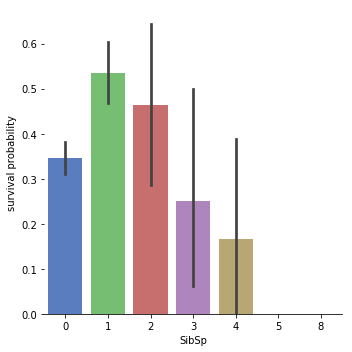

In [122]:
'''
効果が低いと思われるものについても検討
家族が多い人ほど亡くなっているように見える
'''
g = sns.factorplot(x="SibSp",y="Survived",data=titanic_df, kind='bar',size = 5 ,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

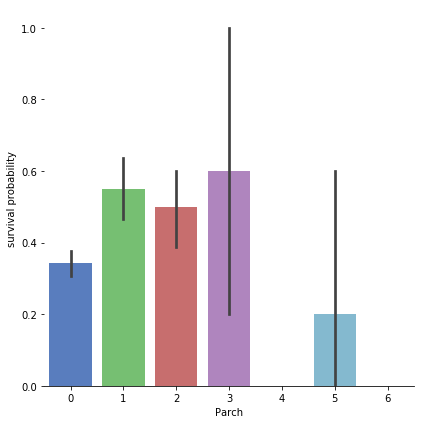

In [129]:
'''
効果が低いと思われるものについても検討
家族が多い人ほど亡くなっているように見える
'''
g  = sns.factorplot(x="Parch",y="Survived",data=titanic_df,kind="bar", size = 6 ,palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

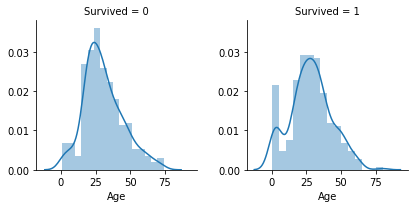

In [130]:
# Explore Age vs Survived
g = sns.FacetGrid(titanic_df, col='Survived')
g = g.map(sns.distplot, "Age")


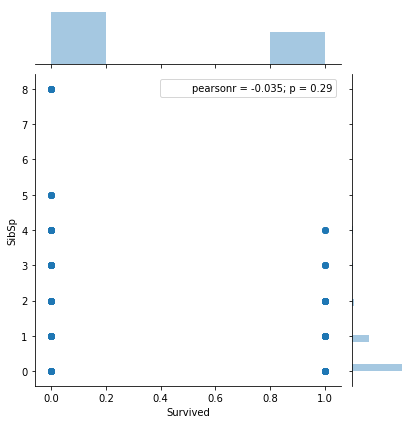

In [49]:
sns.jointplot('Survived','SibSp',data=titanic_df)

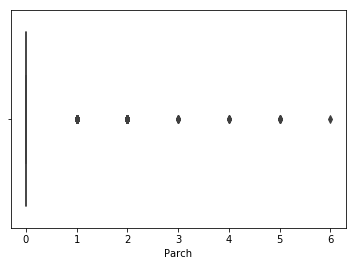

In [17]:

sns.boxplot('Parch',data=titanic_df)

### 文字情報は解析に使用しにくいため、置換する

In [20]:
combine=[titanic_df]
titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] + 1
for titanic_df in combine:
    titanic_df['IsAlone'] = 0
    titanic_df.loc[titanic_df['FamilySize'] == 1, 'IsAlone'] = 1

combine=[test_df]
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"] + 1
for test_df in combine:
    test_df['IsAlone'] = 0
    test_df.loc[test_df['FamilySize'] == 1, 'IsAlone'] = 1

test_data = test_df.values

key =['Pclass','Sex','Age','SibSp','Parch','Fare','Salutation','IsAlone']
xs = titanic_df[key].values # Pclass以降の変数
y  = titanic_df['Survived']  # 正解データ

xs_test=test_df[key].values


In [21]:
key =['Pclass','Sex','Age','SibSp','Parch','Fare','Salutation','IsAlone']
xs = titanic_df[key].values # Pclass以降の変数
y  = titanic_df['Survived']  # 正解データ

xs_test=test_df[key].values

In [22]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier()
random_forest.fit(xs, y)
Y_pred = random_forest.predict(xs_test)

import csv
with open("predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_df['PassengerId'].values.astype(int), Y_pred.astype(int)):
        writer.writerow([pid, survived])

## xgboost

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb

#Split data set to train and test data
X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=0.2, random_state=1)

df_X_train=pd.DataFrame(X_train)
dtrain = xgb.DMatrix(df_X_train.as_matrix(),label=y_train.tolist(), feature_names = feature_names)

df_X_test=pd.DataFrame(X_test)
dtest=xgb.DMatrix(df_X_test.as_matrix())

### データの相関を表示

In [23]:
corrmat = titanic_df.corr()
corrmat

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation,FamilySize,IsAlone
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.033207,-0.057527,-0.001652,0.012658,-0.030323,-0.053849,-0.040143,0.057462
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.069809,-0.035322,0.081629,0.257307,0.101849,0.451099,0.016639,-0.203367
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.331339,0.083081,0.018443,-0.549500,0.050992,-0.018964,0.065997,0.135207
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.084153,0.114631,0.245489,0.182333,0.111249,0.610602,0.200988,-0.303646
Age,0.033207,-0.069809,-0.331339,-0.084153,1.000000,-0.232625,-0.179191,0.091566,0.001932,-0.267648,-0.248512,0.179775
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.232625,1.000000,0.414838,0.159651,-0.058008,0.328015,0.890712,-0.584471
Parch,-0.001652,0.081629,0.018443,0.245489,-0.179191,0.414838,1.000000,0.216225,-0.076625,0.408376,0.783111,-0.583398
Fare,0.012658,0.257307,-0.549500,0.182333,0.091566,0.159651,0.216225,1.000000,0.058462,0.133552,0.217138,-0.271832
Embarked,-0.030323,0.101849,0.050992,0.111249,0.001932,-0.058008,-0.076625,0.058462,1.000000,0.023702,-0.077927,0.014868
Salutation,-0.053849,0.451099,-0.018964,0.610602,-0.267648,0.328015,0.408376,0.133552,0.023702,1.000000,0.428205,-0.487881


### 作った相関のヒートマップを作成する　※１行目はサイズを設定
+ vmax       :最大値
+ vmin       :最小値
+ center     :中央値
+ square     :正方形出力
+ annot      :
+ fmt        :表示する数字の桁数
+ linewidths :ラインの太さ
+ cmap       :色の指定(Reds, Bluesなど)


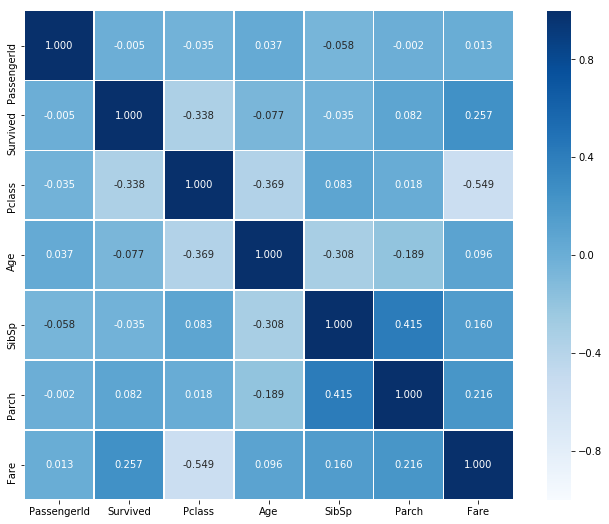

In [57]:
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=1,vmin=-1, square=True, annot=True, fmt='1.3f',linewidths=.5,cmap='Blues',center=0)

ValueError: could not convert string to float: 'C148'

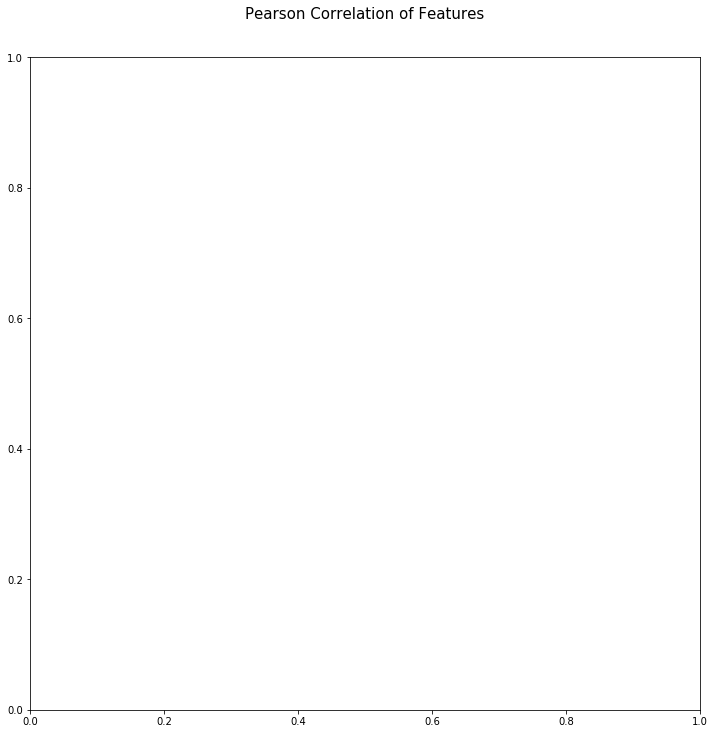

In [25]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
del titanic_df['PassengerId']
sns.heatmap(titanic_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)